# Data Generation: Normal, Uniform, Beta

This first section generates and saves random data samples for later analysis.

Distributions:
- Normal: multiple (mean, variance) pairs
- Uniform: multiple (a,b) ranges
- Beta: multiple (alpha,beta) shapes

Outputs saved under `data/` as `.npy` arrays plus a `manifest.csv` summarizing metadata.
Run cells 2–5 in order.

In [15]:
# Imports and seed
import os, sys, json, time
import numpy as np
import pandas as pd
from scipy import stats

_env_seed = os.getenv('SEED')
if _env_seed is not None:
    try:
        np.random.seed(int(_env_seed))
        print(f"Seed set from SEED env: {_env_seed}")
    except Exception:
        np.random.seed(None)
        print("Invalid SEED provided; using random entropy.")
else:
    np.random.seed(None)
    rng_seed = int(time.time_ns() % (2**32 - 1))
    print(f"Using entropy-based seed; timestamp hint: {rng_seed}")

print('Python:', sys.executable)
print('NumPy:', np.__version__)
print('SciPy:', stats.__version__ if hasattr(stats,'__version__') else 'N/A')

data_root = 'data'
os.makedirs(data_root, exist_ok=True)

Using entropy-based seed; timestamp hint: 4081535455
Python: /Library/Developer/CommandLineTools/usr/bin/python3
NumPy: 2.0.2
SciPy: N/A


In [16]:
# Random parameter definitions
NUM_PARAM_SETS = 4

def random_uniform_params(k: int):
    params = []
    for _ in range(k):
        a = np.random.uniform(-10.0, 5.0)
        width = np.random.uniform(1.0, 15.0)
        b = a + width
        params.append({'a': float(a), 'b': float(b)})
    return params

def random_normal_params(k: int):
    params = []
    for _ in range(k):
        mu = np.random.uniform(-6.0, 6.0)
        log_min, log_max = np.log(0.1), np.log(10.0)
        sigma2 = float(np.exp(np.random.uniform(log_min, log_max)))
        params.append({'mu': float(mu), 'sigma2': float(sigma2)})
    return params

def random_beta_params(k: int):
    params = []
    for _ in range(k):
        alpha_shape = np.random.uniform(0.5, 5.0)
        beta_shape  = np.random.uniform(0.5, 5.0)
        alpha = float(np.random.gamma(shape=alpha_shape, scale=1.0))
        beta  = float(np.random.gamma(shape=beta_shape,  scale=1.0))
        alpha = float(np.clip(alpha, 0.2, 20.0))
        beta  = float(np.clip(beta,  0.2, 20.0))
        params.append({'alpha': alpha, 'beta': beta})
    return params

NORMAL_PARAMS = random_normal_params(NUM_PARAM_SETS)
UNIFORM_PARAMS = random_uniform_params(NUM_PARAM_SETS)
BETA_PARAMS   = random_beta_params(NUM_PARAM_SETS)

SAMPLE_SIZES = [10**3, 5*10**3, 10**4] 
REPEATS = 1  

print('Normal parameter sets:', NORMAL_PARAMS)
print('Uniform parameter sets:', UNIFORM_PARAMS)
print('Beta parameter sets:', BETA_PARAMS)

Normal parameter sets: [{'mu': 5.655530062704015, 'sigma2': 0.20187021903005195}, {'mu': 5.2491262686514215, 'sigma2': 1.89631929075325}, {'mu': -3.2964082228456877, 'sigma2': 3.0793546254936586}, {'mu': -1.0498311280467352, 'sigma2': 0.3885442127362695}]
Uniform parameter sets: [{'a': 4.921406414973892, 'b': 14.082877199762482}, {'a': -8.100656126998716, 'b': -1.2245969034405686}, {'a': 1.91218898543098, 'b': 15.764595046524905}, {'a': 4.309029660047457, 'b': 9.816149933452607}]
Beta parameter sets: [{'alpha': 3.0452144090415914, 'beta': 2.7001507640824562}, {'alpha': 1.1883343751602717, 'beta': 2.35283207427853}, {'alpha': 0.8563204478737931, 'beta': 1.3397088019930086}, {'alpha': 1.1742163756602546, 'beta': 7.6065738445277065}]


In [17]:
# Sampling functions
from typing import Dict, List

def sample_normal(mu: float, sigma2: float, n: int) -> np.ndarray:
    return np.random.normal(loc=mu, scale=np.sqrt(sigma2), size=n)

def sample_uniform(a: float, b: float, n: int) -> np.ndarray:
    return np.random.uniform(low=a, high=b, size=n)

def sample_beta(alpha: float, beta: float, n: int) -> np.ndarray:
    return np.random.beta(a=alpha, b=beta, size=n)

def theoretical_stats(dist: str, params: Dict[str, float]):
    if dist == 'normal':
        return params['mu'], params['sigma2']
    if dist == 'uniform':
        a, b = params['a'], params['b']
        mu = (a + b) / 2
        var = (b - a)**2 / 12
        return mu, var
    if dist == 'beta':
        a, b = params['alpha'], params['beta']
        mu = a / (a + b)
        var = (a * b) / ((a + b)**2 * (a + b + 1))
        return mu, var
    raise ValueError('Unknown dist')

In [18]:
# Generate and save datasets
os.makedirs(data_root, exist_ok=True)
for sub in ['normal','uniform','beta']:
    os.makedirs(os.path.join(data_root, sub), exist_ok=True)

records = []
for n in SAMPLE_SIZES:
    # Normal
    for p in NORMAL_PARAMS:
        x = sample_normal(p['mu'], p['sigma2'], n)
        mu_th, var_th = theoretical_stats('normal', p)
        fname = f"normal_mu{p['mu']}_var{p['sigma2']}_n{n}.npy".replace('.','p')
        path = os.path.join(data_root,'normal', fname)
        np.save(path, x)
        records.append({'distribution':'normal','n':n, **p,'mu_theory':mu_th,'var_theory':var_th,'file':path})
    # Uniform
    for p in UNIFORM_PARAMS:
        x = sample_uniform(p['a'], p['b'], n)
        mu_th, var_th = theoretical_stats('uniform', p)
        fname = f"uniform_a{p['a']}_b{p['b']}_n{n}.npy".replace('.','p')
        path = os.path.join(data_root,'uniform', fname)
        np.save(path, x)
        records.append({'distribution':'uniform','n':n, **p,'mu_theory':mu_th,'var_theory':var_th,'file':path})
    # Beta
    for p in BETA_PARAMS:
        x = sample_beta(p['alpha'], p['beta'], n)
        mu_th, var_th = theoretical_stats('beta', p)
        fname = f"beta_a{p['alpha']}_b{p['beta']}_n{n}.npy".replace('.','p')
        path = os.path.join(data_root,'beta', fname)
        np.save(path, x)
        records.append({'distribution':'beta','n':n, **p,'mu_theory':mu_th,'var_theory':var_th,'file':path})

manifest = pd.DataFrame(records)
manifest_path = os.path.join(data_root,'manifest.csv')
manifest.to_csv(manifest_path, index=False)
print('Saved samples and manifest to', data_root)
manifest

Saved samples and manifest to data


,distribution,n,mu,sigma2,mu_theory,var_theory,file,a,b,alpha,beta
0,normal,1000,5.655530,0.201870,5.655530,0.201870,data/normal/normal_mu5p655530062704015_var0p20...,NaN,NaN,NaN,NaN
1,normal,1000,5.249126,1.896319,5.249126,1.896319,data/normal/normal_mu5p2491262686514215_var1p8...,NaN,NaN,NaN,NaN
2,normal,1000,-3.296408,3.079355,-3.296408,3.079355,data/normal/normal_mu-3p2964082228456877_var3p...,NaN,NaN,NaN,NaN
3,normal,1000,-1.049831,0.388544,-1.049831,0.388544,data/normal/normal_mu-1p0498311280467352_var0p...,NaN,NaN,NaN,NaN
4,uniform,1000,NaN,NaN,9.502142,6.994379,data/uniform/uniform_a4p921406414973892_b14p08...,4.921406,14.082877,NaN,NaN
5,uniform,1000,NaN,NaN,-4.662627,3.940016,data/uniform/uniform_a-8p100656126998716_b-1p2...,-8.100656,-1.224597,NaN,NaN
6,uniform,1000,NaN,NaN,8.838392,15.990763,data/uniform/uniform_a1p91218898543098_b15p764...,1.912189,15.764595,NaN,NaN
7,uniform,1000,NaN,NaN,7.062590,2.527364,data/uniform/uniform_a4p309029660047457_b9p816...,4.309030,9.816150,NaN,NaN
8,beta,1000,NaN,NaN,0.530030,0.036929,data/beta/beta_a3p0452144090415914_b2p70015076...,NaN,NaN,3.045214,2.700151
9,beta,1000,NaN,NaN,0.335577,0.049099,data/beta/beta_a1p1883343751602717_b2p35283207...,NaN,NaN,1.188334,2.352832


# Problem 1: Confidence Intervals — Hoeffding vs Chebyshev

We load saved datasets from `data/manifest.csv`, compute empirical variances, then build and compare confidence intervals for the sample mean using:
- Hoeffding's inequality (requires bounded support [a,b]): applies to Uniform and Beta.
- Chebyshev's inequality (requires variance): applies to all; we use empirical variance.

We present interval width comparisons across distributions, parameters, sample sizes, and multiple confidence levels, plus visual overlays for selected cases.

In [19]:
# Load manifest and helper to load arrays
import pandas as pd
manifest = pd.read_csv('data/manifest.csv')
print('Loaded rows:', len(manifest))
manifest.head()

def bounds_for_row(row):
    if row['distribution'] == 'uniform':
        return float(row['a']), float(row['b'])
    if row['distribution'] == 'beta':
        return 0.0, 1.0
    return -np.inf, np.inf


DELTAS = [0.32, 0.05, 0.003]  # 1σ, 2σ, 3σ

def hoeffding_eps(n, delta, a, b):
    return (b - a) * np.sqrt(np.log(2 / delta) / (2 * n))

def chebyshev_eps(n, delta, var):
    return np.sqrt(var / (n * delta))

Loaded rows: 36


In [20]:
# Build interval table with empirical variance
rows = []
for idx, row in manifest.iterrows():
    file_path = row['file']
    if not file_path.endswith('.npy'):
        file_path = file_path + '.npy'
    x = np.load(file_path)
    n = int(row['n'])
    m = float(np.mean(x))
    var_emp = float(np.var(x, ddof=1))
    a, b = bounds_for_row(row)
    for delta in DELTAS:
        rec = {
            'distribution': row['distribution'],
            'n': n,
            'delta': delta,
            'mean': m,
            'var_emp': var_emp,
        }
        # Hoeffding
        if np.isfinite(a) and np.isfinite(b):
            eps_h = hoeffding_eps(n, delta, a, b)
            rec['hoeff_lo'] = m - eps_h
            rec['hoeff_hi'] = m + eps_h
            rec['w_hoeff'] = 2 * eps_h
        else:
            rec['hoeff_lo'] = np.nan
            rec['hoeff_hi'] = np.nan
            rec['w_hoeff'] = np.nan
        # Chebyshev (empirical variance)
        eps_c = chebyshev_eps(n, delta, var_emp)
        rec['cheb_lo'] = m - eps_c
        rec['cheb_hi'] = m + eps_c
        rec['w_cheb'] = 2 * eps_c
        rows.append(rec)

ci_df = pd.DataFrame(rows)
ci_df

,distribution,n,delta,mean,var_emp,hoeff_lo,hoeff_hi,w_hoeff,cheb_lo,cheb_hi,w_cheb
0,normal,1000,0.320,5.638812,0.212998,NaN,NaN,NaN,5.613013,5.664612,0.051599
1,normal,1000,0.050,5.638812,0.212998,NaN,NaN,NaN,5.573544,5.704080,0.130537
2,normal,1000,0.003,5.638812,0.212998,NaN,NaN,NaN,5.372355,5.905269,0.532914
3,normal,1000,0.320,5.197653,1.853427,NaN,NaN,NaN,5.121548,5.273758,0.152210
4,normal,1000,0.050,5.197653,1.853427,NaN,NaN,NaN,5.005121,5.390185,0.385064
...,...,...,...,...,...,...,...,...,...,...,...
103,beta,10000,0.050,0.397539,0.075289,0.383958,0.411120,0.027162,0.385268,0.409810,0.024542
104,beta,10000,0.003,0.397539,0.075289,0.379508,0.415570,0.036062,0.347443,0.447635,0.100192
105,beta,10000,0.320,0.133683,0.011884,0.124111,0.143255,0.019145,0.131756,0.135610,0.003854
106,beta,10000,0.050,0.133683,0.011884,0.120102,0.147264,0.027162,0.128808,0.138558,0.009751


In [21]:
# Compare interval widths by distribution, n, and delta
summary_w = ci_df.groupby(['distribution','n','delta'])[['w_hoeff','w_cheb']].mean().reset_index()
summary_w.sort_values(['distribution','n','delta']).head(18)

,distribution,n,delta,w_hoeff,w_cheb
0,beta,1000,0.003,0.114038,0.228860
1,beta,1000,0.050,0.085894,0.056059
2,beta,1000,0.320,0.060541,0.022159
3,beta,5000,0.003,0.050999,0.102827
4,beta,5000,0.050,0.038413,0.025187
5,beta,5000,0.320,0.027075,0.009956
6,beta,10000,0.003,0.036062,0.072773
7,beta,10000,0.050,0.027162,0.017826
8,beta,10000,0.320,0.019145,0.007046
9,normal,1000,0.003,NaN,1.194177


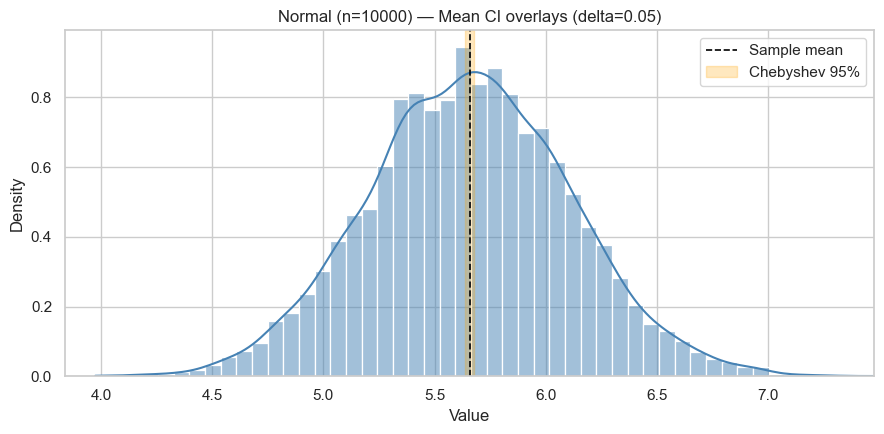

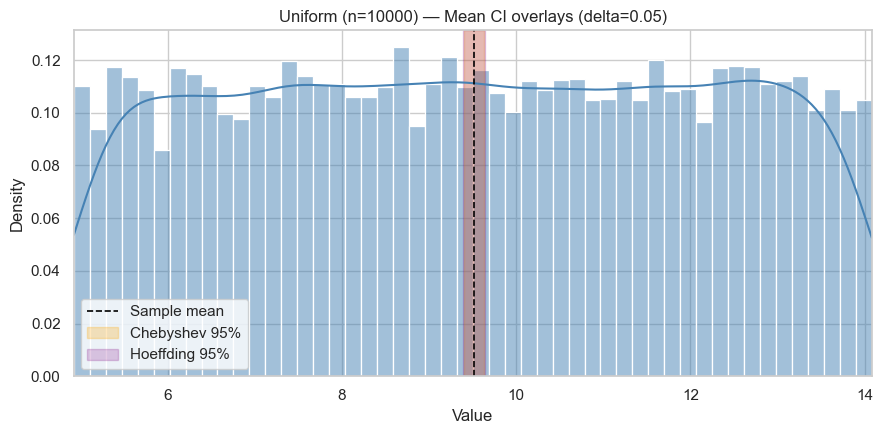

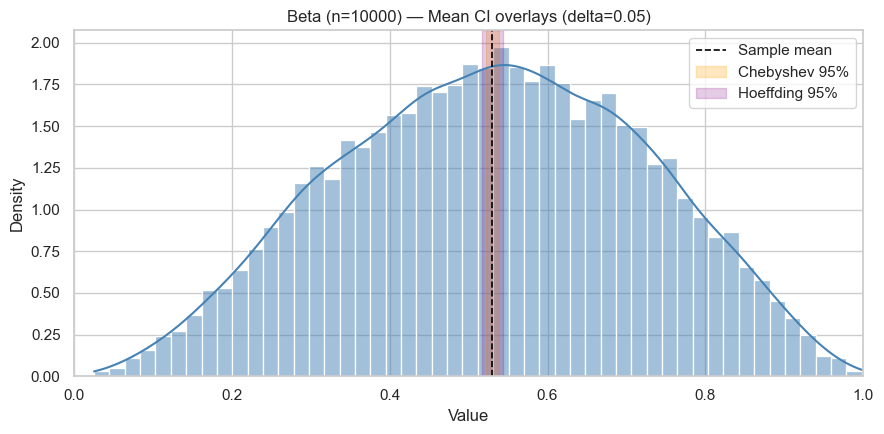

In [22]:
# Visual

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

# pick one example from each distribution at largest n
examples = []
for dist in ['normal','uniform','beta']:
    df = manifest[(manifest['distribution']==dist) & (manifest['n']==manifest['n'].max())]
    if len(df):
        examples.append(df.iloc[0])

for ex in examples:
    file_path = ex['file']
    if not file_path.endswith('.npy'):
        file_path = file_path + '.npy'
    x = np.load(file_path)
    dist = ex['distribution']
    n = int(ex['n'])
    m = float(np.mean(x))
    var_emp = float(np.var(x, ddof=1))
    a, b = bounds_for_row(ex)

    # Choose delta for visualization and compute displayed confidence
    delta = 0.05
    conf = 1 - delta

    # Chebyshev interval
    eps_c = chebyshev_eps(n, delta, var_emp)
    lo_c, hi_c = m - eps_c, m + eps_c
    label_c = f"Chebyshev {int(conf*100)}%"

    # Hoeffding interval (bounded distributions only)
    if np.isfinite(a) and np.isfinite(b):
        eps_h = hoeffding_eps(n, delta, a, b)
        lo_h, hi_h = m - eps_h, m + eps_h
        label_h = f"Hoeffding {int(conf*100)}%"
    else:
        lo_h, hi_h, label_h = np.nan, np.nan, None

    plt.figure(figsize=(9,4.5))
    if np.isfinite(a) and np.isfinite(b):
        xrange = (a, b)
    else:
        std_emp = np.sqrt(var_emp)
        xrange = (m - 4*std_emp, m + 4*std_emp)

    sns.histplot(x, bins=50, stat='density', kde=True, color='steelblue')
    plt.xlim(*xrange)

    plt.axvline(m, color='black', linestyle='--', linewidth=1.2, label='Sample mean')
    plt.axvspan(lo_c, hi_c, color='orange', alpha=0.25, label=label_c)
    if np.isfinite(lo_h):
        plt.axvspan(lo_h, hi_h, color='purple', alpha=0.20, label=label_h)

    plt.title(f"{dist.title()} (n={n}) — Mean CI overlays (delta={delta})")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend(frameon=True)
    plt.tight_layout()
    plt.show()

# Problem 1 Results: Graphs (Overlays)

Below are the consolidated visual results for Problem 1.

- Normal (n=5000): ![Normal CI overlays](figures/1.png)
- Uniform (n=5000): ![Uniform CI overlays](figures/2.png)
- Beta (n=5000): ![Beta CI overlays](figures/3.png)

Additional notes on the results:
- Confidence shown: 95% (delta = 0.05). Orange band is Chebyshev; purple band is Hoeffding (only for bounded Uniform/Beta). Dashed line is the sample mean.
- Interval widths: Hoeffding is consistently tighter than Chebyshev for Uniform/Beta because it uses known bounds [a,b]. Chebyshev is distribution-agnostic but conservative, so bands are wider.
- Scaling with sample size: Both methods shrink as O(1/√n). If you compare n=1000 vs n=5000 cases, the bands narrow accordingly.
- Effect of support range: Under Hoeffding, width increases with (b−a). Wider Uniform ranges or more dispersed Betas produce broader Hoeffding bands.
- Normal data: Hoeffding does not apply (unbounded). Chebyshev provides a valid but wide interval; theoretical z/t intervals (see Problem 2) are more informative for Normal.


# Problem 2: Compare to Theoretical Values

We compare our empirical-variance bounds (Chebyshev) and bounded-support bounds (Hoeffding) against theoretical confidence intervals for the sample mean:
- CLT/z-interval: uses the theoretical variance of the distribution to compute half-width $z_{1-\delta/2}\,\sqrt{\,\mathrm{Var}(X)/n\,}$.
- t-interval: uses the empirical standard deviation with Student-$t$ quantiles (robust for non-Normal at large $n$).
- Normal exact (known variance): when data are Normal and variance is treated as known (theoretical), z-interval is exact under the model.

We add these intervals alongside the existing `ci_df` for direct width comparisons.

In [23]:
# Compute theoretical intervals and compare
import numpy as np
import pandas as pd
from scipy.stats import norm, t

def z_multiplier(delta):
    alpha = delta
    return norm.ppf(1 - alpha/2)

def t_multiplier(delta, df):
    alpha = delta
    return t.ppf(1 - alpha/2, df)

rows_theory = []
for idx, row in manifest.iterrows():
    file_path = row['file']
    if not str(file_path).endswith('.npy'):
        file_path = str(file_path) + '.npy'
    x = np.load(file_path)
    n = int(row['n'])
    m = float(np.mean(x))
    var_emp = float(np.var(x, ddof=1))
    var_th = float(row['var_theory'])
    for delta in DELTAS:
        z = z_multiplier(delta)
        # CLT/z using theoretical variance
        eps_z_th = z * np.sqrt(var_th / n)
        lo_z_th, hi_z_th = m - eps_z_th, m + eps_z_th
        # t-interval using empirical std
        df = max(n - 1, 1)
        tm = t_multiplier(delta, df)
        eps_t = tm * np.sqrt(var_emp / n)
        lo_t, hi_t = m - eps_t, m + eps_t
        
        rows_theory.append({
            'distribution': row['distribution'],
            'n': n,
            'delta': delta,
            'mean': m,
            'lo_z_theory': lo_z_th,
            'hi_z_theory': hi_z_th,
            'w_z_theory': 2*eps_z_th,
            'lo_t': lo_t,
            'hi_t': hi_t,
            'w_t': 2*eps_t
        })

theory_df = pd.DataFrame(rows_theory)
keys = ['distribution','n','delta','mean']
compare_df = pd.merge(ci_df, theory_df, on=keys, how='left')

compare_df = compare_df.rename(columns={
    'distribution': 'Distribution',
    'n': 'Sample Size',
    'delta': 'Delta (two-sided tail prob)',
    'mean': 'Sample Mean',
    'var_emp': 'Empirical Variance',
    'hoeff_lo': 'Hoeffding Lower',
    'hoeff_hi': 'Hoeffding Upper',
    'w_hoeff': 'Hoeffding Width',
    'cheb_lo': 'Chebyshev Lower',
    'cheb_hi': 'Chebyshev Upper',
    'w_cheb': 'Chebyshev Width',
    'lo_z_theory': 'Z-Theory Lower',
    'hi_z_theory': 'Z-Theory Upper',
    'w_z_theory': 'Z-Theory Width',
    'lo_t': 't Lower',
    'hi_t': 't Upper',
    'w_t': 't Width'
})

compare_df

,Distribution,Sample Size,Delta (two-sided tail prob),Sample Mean,Empirical Variance,Hoeffding Lower,Hoeffding Upper,Hoeffding Width,Chebyshev Lower,Chebyshev Upper,Chebyshev Width,Z-Theory Lower,Z-Theory Upper,Z-Theory Width,t Lower,t Upper,t Width
0,normal,1000,0.320,5.638812,0.212998,NaN,NaN,NaN,5.613013,5.664612,0.051599,5.624683,5.652941,0.028259,5.624291,5.653333,0.029042
1,normal,1000,0.050,5.638812,0.212998,NaN,NaN,NaN,5.573544,5.704080,0.130537,5.610965,5.666659,0.055695,5.610173,5.667451,0.057279
2,normal,1000,0.003,5.638812,0.212998,NaN,NaN,NaN,5.372355,5.905269,0.532914,5.596646,5.680978,0.084332,5.595393,5.682231,0.086838
3,normal,1000,0.320,5.197653,1.853427,NaN,NaN,NaN,5.121548,5.273758,0.152210,5.154348,5.240959,0.086611,5.154819,5.240487,0.085668
4,normal,1000,0.050,5.197653,1.853427,NaN,NaN,NaN,5.005121,5.390185,0.385064,5.112303,5.283003,0.170700,5.113172,5.282135,0.168963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,beta,10000,0.050,0.397539,0.075289,0.383958,0.411120,0.027162,0.385268,0.409810,0.024542,0.392192,0.402887,0.010694,0.392161,0.402918,0.010757
104,beta,10000,0.003,0.397539,0.075289,0.379508,0.415570,0.036062,0.347443,0.447635,0.100192,0.389443,0.405636,0.016193,0.389394,0.405684,0.016290
105,beta,10000,0.320,0.133683,0.011884,0.124111,0.143255,0.019145,0.131756,0.135610,0.003854,0.132601,0.134765,0.002165,0.132599,0.134767,0.002168
106,beta,10000,0.050,0.133683,0.011884,0.120102,0.147264,0.027162,0.128808,0.138558,0.009751,0.131550,0.135816,0.004266,0.131546,0.135820,0.004274


In [24]:
# Summaries
cols = ['Distribution','Sample Size','Delta (two-sided tail prob)',
        'Chebyshev Width','Hoeffding Width','Z-Theory Width','t Width']
summary_cmp = compare_df[cols].groupby(['Distribution','Sample Size','Delta (two-sided tail prob)']).mean().reset_index()
summary_cmp = summary_cmp.sort_values(['Distribution','Sample Size','Delta (two-sided tail prob)'])
summary_cmp

,Distribution,Sample Size,Delta (two-sided tail prob),Chebyshev Width,Hoeffding Width,Z-Theory Width,t Width
0,beta,1000,0.003,0.228860,0.114038,0.037324,0.037293
1,beta,1000,0.050,0.056059,0.085894,0.024649,0.024598
2,beta,1000,0.320,0.022159,0.060541,0.012507,0.012472
3,beta,5000,0.003,0.102827,0.050999,0.016692,0.016723
4,beta,5000,0.050,0.025187,0.038413,0.011024,0.011041
5,beta,5000,0.320,0.009956,0.027075,0.005593,0.005601
6,beta,10000,0.003,0.072773,0.036062,0.011803,0.011832
7,beta,10000,0.050,0.017826,0.027162,0.007795,0.007813
8,beta,10000,0.320,0.007046,0.019145,0.003955,0.003964
9,normal,1000,0.003,1.194177,NaN,0.197293,0.194591


# Conclusions for Problem 2

- Chebyshev: Provides very conservative intervals; widest bands overall, especially at smaller `n`. Useful when variance is finite but distribution is unknown.
- Hoeffding: Tighter than Chebyshev for bounded distributions (Uniform, Beta). Width scales with range `(b−a)`; not applicable to unbounded Normal.
- z-Theory (CLT/known variance): Narrow and accurate when using theoretical variance; matches Normal model assumptions best.
- t-interval: Slightly wider than z for small `n` due to estimating variance; approaches z as `n` grows.

Summary: For Normal data, theoretical z/t intervals are the most informative. For bounded non-Normal (Uniform/Beta), Hoeffding outperforms Chebyshev. Chebyshev is a safe fallback but typically overly wide.

# Problem 3: 68–95–99.7 Rule Coverage

We assess the empirical coverage of the intervals `[mean ± 1·std]`, `[mean ± 2·std]`, `[mean ± 3·std]` for each saved dataset.
The empirical rule states that for Normal data, approximately 68%, 95%, and 99.7% of observations lie within 1, 2, and 3 standard deviations of the mean, respectively.

Notes:
- We use the sample mean and sample standard deviation (ddof=1).
- The rule is exact for Normal in the limit; for finite samples, small deviations are expected.
- For bounded or skewed distributions (Uniform, Beta), coverage will generally differ.

In [25]:
# Compute empirical coverage for 1σ, 2σ, 3σ
import numpy as np
import pandas as pd

def coverage_rates(arr):
    m = float(np.mean(arr))
    s = float(np.std(arr, ddof=1))
    if s == 0:
        return { 'cov_1sigma': np.nan, 'cov_2sigma': np.nan, 'cov_3sigma': np.nan }
    diffs = np.abs(arr - m)
    return {
        'cov_1sigma': float(np.mean(diffs <= 1*s)),
        'cov_2sigma': float(np.mean(diffs <= 2*s)),
        'cov_3sigma': float(np.mean(diffs <= 3*s)),
    }

cov_rows = []
for idx, row in manifest.iterrows():
    file_path = row['file']
    if not str(file_path).endswith('.npy'):
        file_path = str(file_path) + '.npy'
    x = np.load(file_path)
    rates = coverage_rates(x)
    cov_rows.append({
        'Distribution': row['distribution'],
        'Sample Size': int(row['n']),
        **rates
    })

cov_df = pd.DataFrame(cov_rows)
cov_summary = cov_df.groupby(['Distribution','Sample Size']).mean().reset_index()
cov_summary

,Distribution,Sample Size,cov_1sigma,cov_2sigma,cov_3sigma
0,beta,1000,0.653500,0.96300,0.996250
1,beta,5000,0.649200,0.96645,0.996800
2,beta,10000,0.649225,0.96655,0.996750
3,normal,1000,0.680000,0.95525,0.996500
4,normal,5000,0.685450,0.95320,0.997650
5,normal,10000,0.683000,0.95385,0.997725
6,uniform,1000,0.587500,1.00000,1.000000
7,uniform,5000,0.580450,1.00000,1.000000
8,uniform,10000,0.577825,1.00000,1.000000


In [26]:
# Interpret coverage vs 68–95–99.7 rule
expected = {'cov_1sigma': 0.68, 'cov_2sigma': 0.95, 'cov_3sigma': 0.997}
cov_summary.assign(
    delta_1 = cov_summary['cov_1sigma'] - expected['cov_1sigma'],
    delta_2 = cov_summary['cov_2sigma'] - expected['cov_2sigma'],
    delta_3 = cov_summary['cov_3sigma'] - expected['cov_3sigma']
)

,Distribution,Sample Size,cov_1sigma,cov_2sigma,cov_3sigma,delta_1,delta_2,delta_3
0,beta,1000,0.653500,0.96300,0.996250,-0.026500,0.01300,-0.000750
1,beta,5000,0.649200,0.96645,0.996800,-0.030800,0.01645,-0.000200
2,beta,10000,0.649225,0.96655,0.996750,-0.030775,0.01655,-0.000250
3,normal,1000,0.680000,0.95525,0.996500,0.000000,0.00525,-0.000500
4,normal,5000,0.685450,0.95320,0.997650,0.005450,0.00320,0.000650
5,normal,10000,0.683000,0.95385,0.997725,0.003000,0.00385,0.000725
6,uniform,1000,0.587500,1.00000,1.000000,-0.092500,0.05000,0.003000
7,uniform,5000,0.580450,1.00000,1.000000,-0.099550,0.05000,0.003000
8,uniform,10000,0.577825,1.00000,1.000000,-0.102175,0.05000,0.003000


# Conclusions for Problem 3

- Normal: Coverage closely matches 68–95–99.7, especially at larger `n`. Small deviations are expected due to finite sampling.
- Uniform: Coverage within k·σ differs from Normal since Uniform is bounded and not bell-shaped; expect lower tails at 3σ due to finite support.
- Beta: Coverage depends on shape (α,β). Symmetric, unimodal Betas with large α+β may approximate Normal behavior; skewed or U-shaped Betas deviate substantially.

Overall, the 68–95–99.7 rule holds for approximately Normal distributions; it does not strictly hold for non-Normal (bounded or skewed) distributions.